# Uncertainty evaluation
We analyze the models' predictive uncertainty.

In [1]:
import string

import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.utils import ROOT_DIR

In [2]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/paper"

# Register dask progress bar
ProgressBar(minimum=5).register()


In [3]:
our_store = (
    ROOT_DIR / "models/predictions/ensemble-mixed/ensemble-mixed_era_best-mae.zarr"
)
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
our = xr.open_zarr(our_store)

pred = our.twsa
sigma = our.sigma
sigma_ale = our.sigma_ale
sigma_epi = our.sigma_epi

grace_name = "twsa_csr"

## Uncertainty map plot

In [4]:
# Compute mean uncertainty over time
sigma_mean = sigma.mean("time").compute()


In [5]:
# Colorbar position: right
plot_kwargs = dict(
    rasterized=True,
    coastlines=True,
    gridlines=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
    cbar_kwargs=dict(location="right", aspect=15, shrink=0.93, pad=0.03),
)


Uncertainty ratio:

$$ \frac{\sigma^2_\text{ale}}{\sigma^2_\text{epi}} $$

In [6]:
vari_ratio = (sigma_ale**2) / (sigma_epi**2)

In [7]:
from matplotlib import colors

In [8]:
vari_ratio.mean("time").compute().min()

<xarray.DataArray ()> Size: 4B
array(2.4716322, dtype=float32)

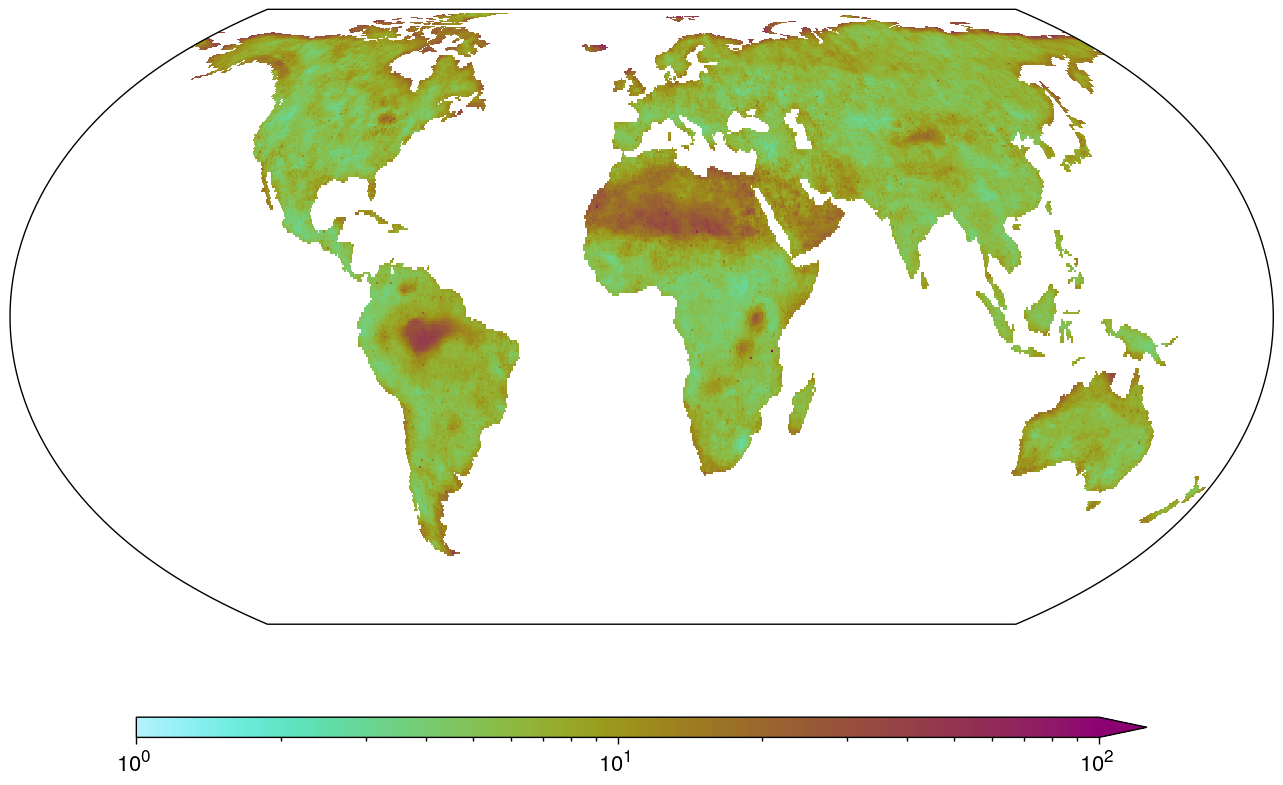

In [9]:
vari_ratio.mean("time").dr.projplot(
    vmin=1,
    vmax=100,
    norm=colors.LogNorm(),
    cmap=cmc.hawaii_r,
)

Uncertainty delta: Where did the uncertainty change the most? We substract the year-average uncertainty of 2021 from the year-average uncertainty of 2004 (the first GRACE year without missing months). We do the same for the reconstruction period

In [10]:
sigma_delta_grace = sigma.sel(time="2021").mean("time") - sigma.sel(time="2004").mean(
    "time"
)
sigma_delta_pregrace = sigma.sel(time="2001").mean("time") - sigma.sel(
    time="1941"
).mean("time")

## Create plot

In [11]:
sigma_kwargs = dict(
    vmin=0,
    vmax=120,
    cmap=cmc.lapaz_r,
    rasterized=True,
    coastlines=True,
    gridlines=True,
    add_colorbar=False,
    cbar_kwargs=None,
)
ratio_kwargs = dict(
    vmin=1,
    vmax=100,
    norm=colors.LogNorm(),
    cmap=cmc.hawaii_r,
    rasterized=True,
    coastlines=True,
    gridlines=True,
    cbar_kwargs=None,
    add_colorbar=False,
)
delta_kwargs = dict(
    vmax=100,
    cmap=cmc.vik,
    rasterized=True,
    coastlines=True,
    gridlines=True,
    cbar_kwargs=None,
    add_colorbar=False,
)


In [12]:
def calc_shrink(n: int) -> float:
    """Calculate the cbar shrink factor based on the number of plot columns"""
    SHRINK_FACTOR = 0.4
    return 1.0 - SHRINK_FACTOR / n


def calc_aspect(n: int) -> float:
    """Calculate the cbar aspect ratio based on the number of plot columns"""
    HEIGHT = 0.025
    width = calc_shrink(n) * n
    return width / HEIGHT


def calc_extendfrac(n: int) -> float:
    """Calculate the cbar extension fraction based on the number of plot columns"""
    EXTEND_FRAC = 0.05
    width = calc_shrink(n) * n
    return EXTEND_FRAC / width


# Cbar triangular extension length
EXTEND_LENGTH = 0.05

In [13]:
# Oceanic Niño Index
oni = inps.oni


In [14]:
# Calculate time series of uncertainty and RMSE
# (3 month running average similar to ONI)
sigma_tseries = (
    sigma.dr.weight_lat()
    .mean(["lat", "lon"])
    # .rolling(time=3, center=True)
    # .mean()
    .compute()
)
sigma_ale_tseries = (
    sigma_ale.dr.weight_lat()
    .mean(["lat", "lon"])
    # .rolling(time=3, center=True)
    # .mean()
    .compute()
)
sigma_epi_tseries = (
    sigma_epi.dr.weight_lat()
    .mean(["lat", "lon"])
    # .rolling(time=3, center=True)
    # .mean()
    .compute()
)
rmse_tseries = (
    metrics.rmse(
        tgts[grace_name],
        pred,
        dim=[],
    )
    .dr.weight_lat()
    .mean(["lat", "lon"])
    # .rolling(time=3, center=True, min_periods=1)
    # .mean()
    .compute()
)

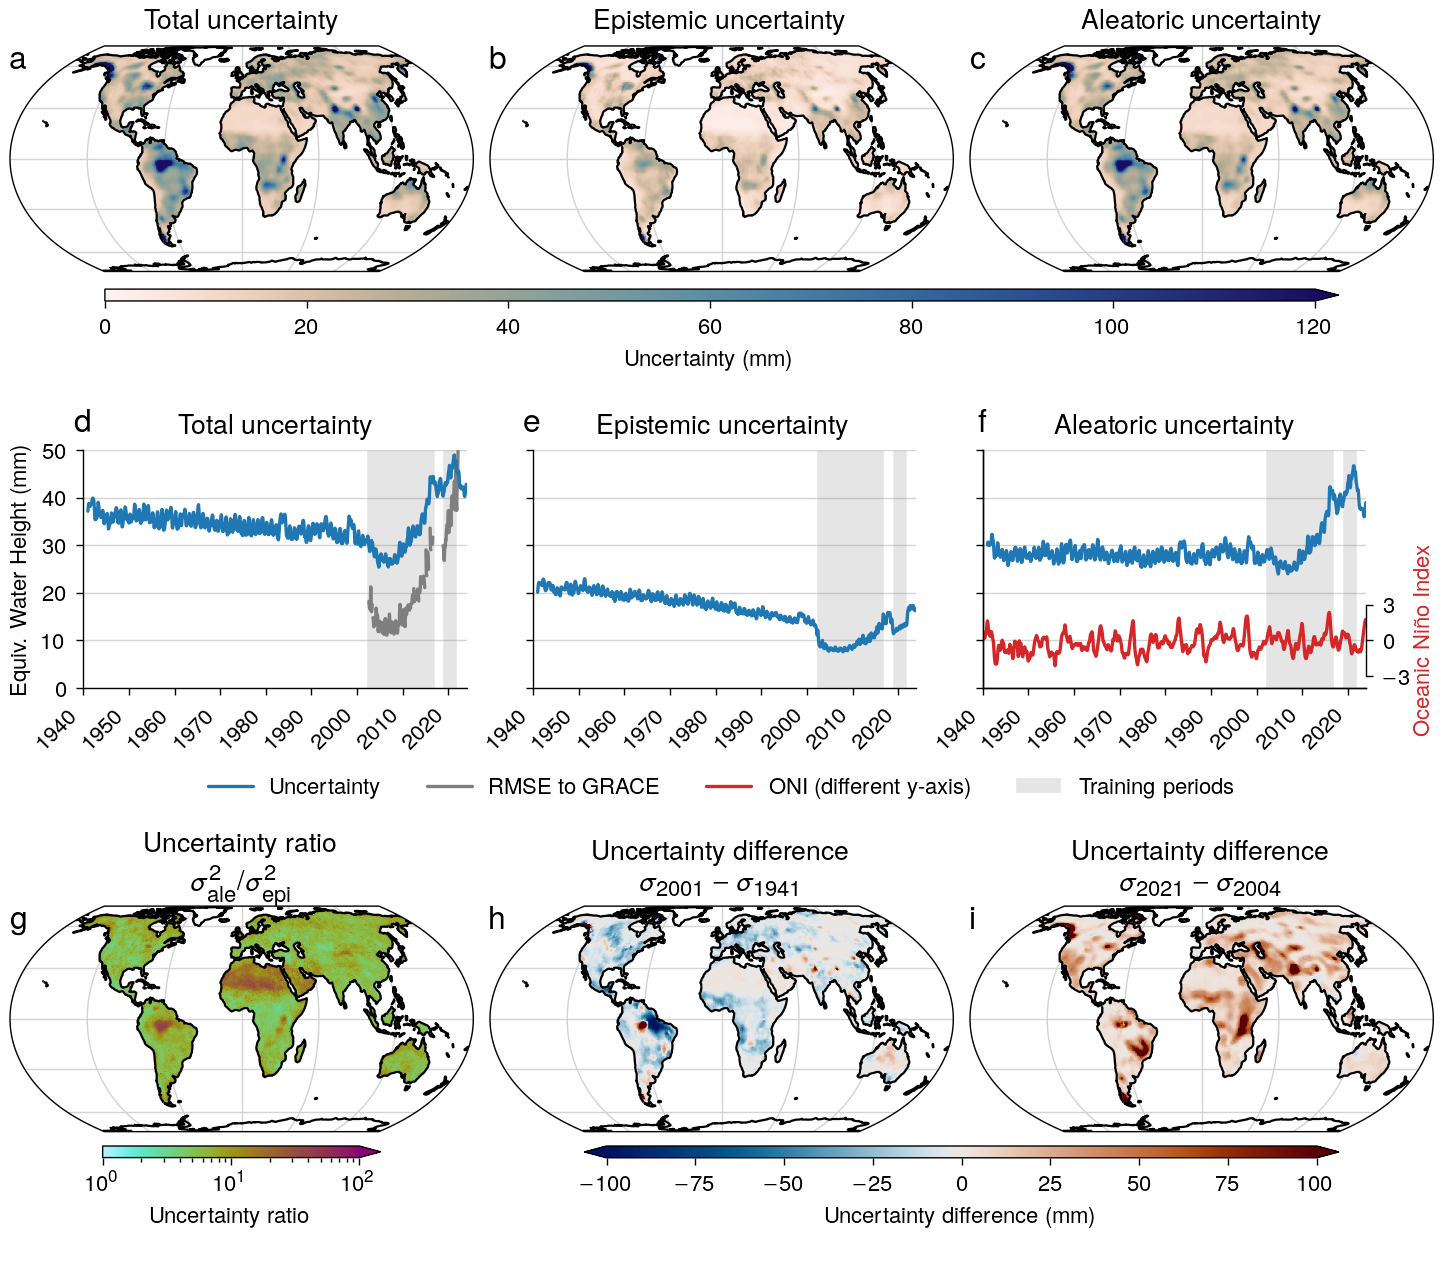

In [15]:
fig = plt.figure(figsize=(7.2, 6.5))
subfigs = fig.subfigures(nrows=3, hspace=0.05)

axs_geo1 = subfigs[0].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})
axs_line = subfigs[1].subplots(1, 3, sharex=True, sharey=True)
axs_geo2 = subfigs[2].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})

### Uncertainty components map plots ###
p_sigma = sigma.mean("time").dr.projplot(ax=axs_geo1[0], **sigma_kwargs)
sigma_epi.mean("time").dr.projplot(ax=axs_geo1[1], **sigma_kwargs)
sigma_ale.mean("time").dr.projplot(ax=axs_geo1[2], **sigma_kwargs)

# Titles
axs_geo1[0].set(title="Total uncertainty")
axs_geo1[1].set(title="Epistemic uncertainty")
axs_geo1[2].set(title="Aleatoric uncertainty")

# Colorbar
subfigs[0].colorbar(
    p_sigma,
    ax=axs_geo1,
    label="Uncertainty (mm)",
    location="bottom",
    aspect=calc_aspect(3),
    shrink=calc_shrink(3),
    extendfrac=calc_extendfrac(3),
    extend="max",
)


### Uncertainty components timeseries ###

sigma_color = "tab:blue"
rmse_color = "tab:gray"
(p_rmse_ts,) = rmse_tseries.plot(ax=axs_line[0], color=rmse_color)
(p_sigma_ts,) = sigma_tseries.plot(ax=axs_line[0], color=sigma_color)
sigma_epi_tseries.plot(ax=axs_line[1], color=sigma_color)
sigma_ale_tseries.plot(ax=axs_line[2], color=sigma_color)

axs_line[0].set(
    ylim=(0, 50),
    title="Total uncertainty",
    xlabel=None,
    xlim=(pd.Timestamp("1940-01-01"), pd.Timestamp("2023-12-31")),
)
axs_line[0].set_ylabel("Equiv. Water Height (mm)")
axs_line[1].set(title="Epistemic uncertainty", xlabel=None, ylabel=None)
axs_line[2].set(title="Aleatoric uncertainty", xlabel=None, ylabel=None)


# Secondary axis for ONI
ax_oni = axs_line[2].twinx()
oni_color = "tab:red"
oni_ticks = np.array([-3, 0, 3])
(p_oni,) = oni.plot(ax=ax_oni, color=oni_color)
ax_oni.set(ylim=(-4, 4 * 4), yticks=oni_ticks)
ax_oni.set_ylabel("Oceanic Niño Index", color=oni_color)

oni_spine = ax_oni.spines.right
oni_spine.set_visible(True)
oni_spine.set_bounds(oni_ticks.min(), oni_ticks.max())

trans = ax_oni.get_yaxis_transform()
ax_oni.yaxis.set_label_coords(1.12, 0, transform=trans)

for ax in axs_line:
    # Mark training periods
    # OG GRACE
    box = ax.axvspan(
        pd.Timestamp("2002-03-01"),
        pd.Timestamp("2017-01-01"),
        facecolor="tab:gray",
        alpha=0.2,
    )
    # GRACE-FO
    ax.axvspan(
        pd.Timestamp("2018-11-01"),
        pd.Timestamp("2021-12-01"),
        facecolor="tab:gray",
        alpha=0.2,
    )
    ax.label_outer()
    ax.yaxis.grid()

    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

# Add legend
handles = [p_sigma_ts, p_rmse_ts, p_oni, box]
labels = [
    "Uncertainty",
    "RMSE to GRACE",
    "ONI (different y-axis)",
    "Training periods",
]
subfigs[1].legend(handles, labels, loc="outside lower center", ncol=len(handles))


### Uncertainty ratio ###
p_ratio = vari_ratio.mean("time").dr.projplot(ax=axs_geo2[0], **ratio_kwargs)

axs_geo2[0].set(
    title="Uncertainty ratio\n" + r"$\sigma^2_\text{ale} / \sigma^2_\text{epi}$"
)

subfigs[2].colorbar(
    p_ratio,
    ax=axs_geo2[0],
    label="Uncertainty ratio\n",
    location="bottom",
    aspect=calc_aspect(1),
    shrink=calc_shrink(1),
    extendfrac=calc_extendfrac(1),
    extend="max",
)

### Uncertainty delta ###
p_delta = sigma_delta_pregrace.dr.projplot(ax=axs_geo2[1], **delta_kwargs)
sigma_delta_grace.dr.projplot(ax=axs_geo2[2], **delta_kwargs)

axs_geo2[1].set(
    title="Uncertainty difference\n" + r"$\sigma_\text{2001}-\sigma_\text{1941}$"
)
axs_geo2[2].set(
    title="Uncertainty difference\n" + r"$\sigma_\text{2021}-\sigma_\text{2004}$"
)

subfigs[2].colorbar(
    p_delta,
    ax=axs_geo2[1:],
    label="Uncertainty difference (mm)",
    location="bottom",
    aspect=calc_aspect(2),
    shrink=calc_shrink(2),
    extendfrac=calc_extendfrac(2),
    extend="both",
)

### Add letters ###
for n, ax in enumerate(axs_geo1):
    ax.text(
        0.0,
        1.0 - 0.10,
        string.ascii_lowercase[n],
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )
for n, ax in enumerate(axs_line):
    ax.text(
        0.0,
        1.0 + 0.08,
        string.ascii_lowercase[n + len(axs_geo1)],
        ha="center",
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )
for n, ax in enumerate(axs_geo2):
    ax.text(
        0.0,
        1.0 - 0.10,
        string.ascii_lowercase[n + len(axs_geo1) + len(axs_line)],
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )

fig.savefig(FIGURE_DIR / "uncertainty.pdf", backend="pgf")